In [1]:
# Imports

import os
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Do not display decimals
pd.options.display.float_format = '{:,.0f}'.format

In [4]:
# Define data dir

dataDir = os.path.abspath("./Data/Bar Data")
print("Reading from " + dataDir)

Reading from /Users/jonathanhasenburg/git/jupyter-examples/Data/Bar Data


In [6]:
# Read in data

dataNormal = []
with open(dataDir + "/normal.log", "r") as f:
    for i, line in enumerate(f):
        info_split = line.split("   - ")
        if len(info_split) > 1:
            info = info_split[1]
            if info.startswith("GEOLIFE_STOP_INDEX="):
                # ok, that's our line
                d = []
                split = info.split(",")
                for s in split:
                    val = s.split("=")[1]
                    d.append(float(val.replace("\n", "")))
                dataNormal.append(d)

dataNoContext = []
with open(dataDir + "/noContext.log", "r") as f:
    for i, line in enumerate(f):
        info_split = line.split("   - ")
        if len(info_split) > 1:
            info = info_split[1]
            if info.startswith("GEOLIFE_STOP_INDEX="):
                # ok, that's our line
                d = []
                split = info.split(",")
                for s in split:
                    val = s.split("=")[1]
                    d.append(float(val.replace("\n", "")))
                dataNoContext.append(d)
                
print("normal measurements: {0!s}, noContext measurements: {1!s}".format(len(dataNormal), len(dataNoContext)))
data = []
for i, line in enumerate(dataNormal):
    line.append(dataNoContext[i][4])
    data.append(line)
    
df = pd.DataFrame(data,columns=["clients", "update_ops", "publish_ops", "granularity", "throughputNormal", "throughputNoContext"])

normal measurements: 140, noContext measurements: 140


In [11]:
# Prepare operation dataframes
df['totalized_throughputNormal'] = df.throughputNormal * df.clients
df['totalized_throughputNoContext'] = df.throughputNoContext * df.clients

gran25 = df[(df['granularity'] == 25)]

op991 = gran25[(gran25['update_ops'] == 99.0) & (df['publish_ops'] == 1.0)]
op11 = gran25[(gran25['update_ops'] == 1.0) & (df['publish_ops'] == 1.0)]
op110 = gran25[(gran25['update_ops'] == 1.0) & (df['publish_ops'] == 10.0)]
op199 = gran25[(gran25['update_ops'] == 1.0) & (df['publish_ops'] == 99.0)]

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  import sys
/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:9: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if __name__ == '__main__':
/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.


<Figure size 432x288 with 0 Axes>

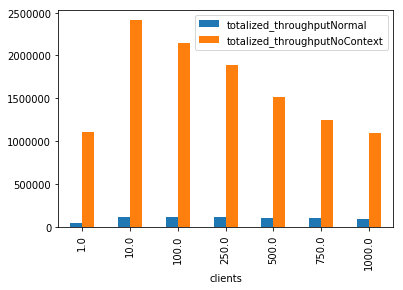

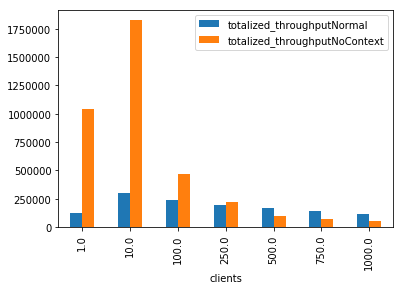

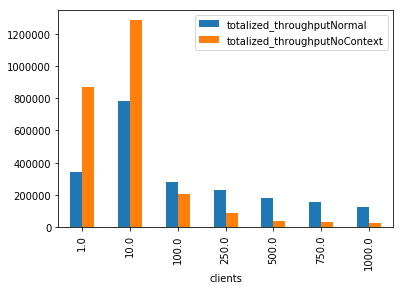

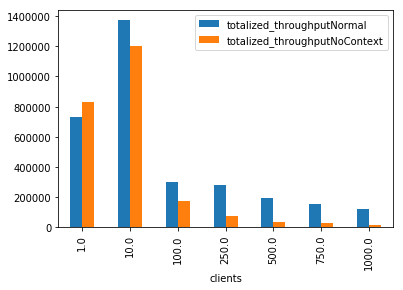

In [15]:
# Plot absolute numbers

toPlot = []
names = ["op99-1", "op1-1", "op1-10", "op1-99"]

toPlot.append(op991)
toPlot.append(op11)
toPlot.append(op110)
toPlot.append(op199)

i = 0
for toP in toPlot:
    file = dataDir + "/bar_" + names[i] + ".pdf"
    fig = plt.figure(i)

    toP.plot.bar(x="clients", y=["totalized_throughputNormal", "totalized_throughputNoContext"])
    i = i + 1
    fig.savefig(file)

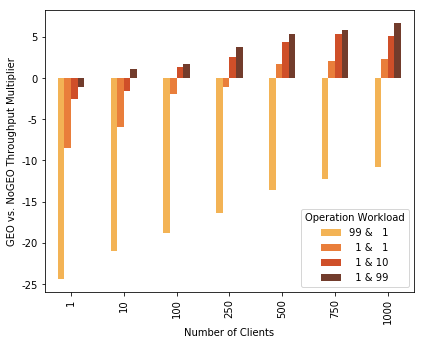

In [17]:
# Plot all overheads

tmps = [op991, op11, op110, op199]
names = ["99 &   1", "  1 &   1", "  1 & 10", "  1 & 99"]
color = ["#F3B355", "#E97E3B", "#CF4F29", "#723C2C"]

# Creaet an empty dataframe wth the correct columns for easy merging
tmp_merged = tmps[0].drop(columns=['update_ops', 'publish_ops', 'granularity', 'throughputNormal', 'throughputNoContext', 'totalized_throughputNormal', 'totalized_throughputNoContext'])

i = 0
for tmp in tmps:
    tmp = tmp.drop(columns=['update_ops', 'publish_ops', 'granularity', 'throughputNormal', 'throughputNoContext'])
    name_noContext = "faster_noContext_" + names[i]
    name_normal = "faster_normal_" + names[i]
    # add column that has positive values for one and negative values for other
    vals = []
    for index, row in tmp.iterrows():
        val = -1 * (row.totalized_throughputNoContext / row.totalized_throughputNormal)
        if val > -1:
            val = 1 * (row.totalized_throughputNormal / row.totalized_throughputNoContext)
        vals.append(val)
    
    tmp[names[i]] = vals
    tmp = tmp.drop(columns=['totalized_throughputNormal', 'totalized_throughputNoContext'])
    tmp_merged = tmp_merged.merge(tmp, on="clients")
    i = i + 1

ax = tmp_merged.plot.bar(x="clients", color=color, figsize=(6,4.9))

# Update labels
labels = [1, 10, 100, 250, 500, 750, 1000]
ax.set_xticklabels(labels)
ax.set_xlabel("Number of Clients")

labels = []
for label in ax.get_yticks():
    label = "{:.0f}".format(label)
    labels.append(label)

ax.set_yticklabels(labels)
ax.set_ylabel("GEO vs. NoGEO Throughput Multiplier")

ax.get_legend().set_title("Operation Workload")

fig = ax.get_figure()
fig.tight_layout()
fig.savefig(dataDir + "/storage_normalVsNoContext.pdf")